# Process the raw Rio de Janeiro magnetic data

The data come in a bad text format and there is some cleaning and processing that we need to do:

1. Convert to standard CSV for easier reading with Pandas.
2. Convert longitude and latitude coordinates to WGS84
3. Calculate the geometric height since they only give the "distance to the ground"
4. Add projected easting and northing coordinates using a Mercator projection instead of the UTM coordinates given in 2 different zones.
5. Remove the tie lines since they seem to be a bit bad.
6. Crop the data to a smaller area with some interesting anomalies.
7. Calculate derivatives of the line data using equivalent sources.

In [1]:
import pathlib
import tarfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyproj
import verde as vd
import harmonica as hm
from pyproj import Transformer
import pygmt
import xarray as xr
import warnings

In [2]:
warnings.filterwarnings("ignore")

## Load the data

Read the data in from the custom xyz format in which it's distributed by SGB.

In [3]:
data_dir = pathlib.Path("..") / "data"
raw_dir = data_dir / "raw"
processed_dir = data_dir / "processed"

In [4]:
data_path = raw_dir / "1038_XYZ.tar.xz"
with tarfile.open(data_path) as archive:
    with archive.extractfile("1038_XYZ/1038/spaulo_rjaneiro_rj.xyz") as data_file:
        raw_data = []
        usecols = [2, 3, 4, 18]
        read_data = False
        for i, line in enumerate(data_file):
            line = line.decode("latin1")
            if i < 5:
                continue
            if line.strip().startswith("LINE"):
                line_no = int(line.strip().split()[-1][:-1])
                read_data = True
                continue
            # Skip the tie lines because some of them are bad
            if line.strip().startswith("TIE"):
                read_data = False
                continue
            if read_data:
                columns = [float(c.strip()) for c in line.strip().split()]
                raw_data.append([columns[c] for c in usecols] + [line_no])
    full_data = pd.DataFrame(
        raw_data,
        columns=[
            "longitude",
            "latitude",
            "total_field_anomaly_nT",
            "altitude_m",
            "line_number",
        ],
    )
full_data

longitude   latitude  total_field_anomaly_nT  altitude_m  line_number
0      -43.995285 -23.100388                  444.36      300.00           20
1      -43.995255 -23.099503                  434.32      300.00           20
2      -43.995224 -23.098618                  426.28      300.00           20
3      -43.995193 -23.097733                  418.24      300.00           20
4      -43.995178 -23.096832                  410.20      300.00           20
...           ...        ...                     ...         ...          ...
393290 -40.966003 -21.270996                   11.26      143.87         6500
393291 -40.965988 -21.270111                   13.17      143.87         6500
393292 -40.965988 -21.269211                   11.08      143.87         6500
393293 -40.965973 -21.268311                   11.00      143.87         6500
393294 -40.965973 -21.267426                    8.91      143.56         6500

[393295 rows x 5 columns]

## Crop the data to a better region

This region contains some of the intrusions and lineaments and none of the worse flight lines.

In [5]:
region = [-42.64, -41.9, -22.6, -22]
data = (
    full_data.loc[vd.inside((full_data.longitude, full_data.latitude), region)]
    .reset_index(drop=True)
    .copy()
)
data.head()

longitude   latitude  total_field_anomaly_nT  altitude_m  line_number
0 -42.639984 -22.290527                  -16.56      151.49         2800
1 -42.639969 -22.291397                  -43.47      162.46         2800
2 -42.639954 -22.292267                  -65.38      170.69         2800
3 -42.639938 -22.293152                  -74.29      173.43         2800
4 -42.639923 -22.294022                  -67.20      170.08         2800

## Convert coordinates from the Hayford 1910 ellipsoid to WGS84 system

The documentation in the data distribution says that the ellipsoid used was the Hayford 1910, though there isn't much in the way of documentation for this. [EPSG:4225](https://epsg.io/4225) is our best guess at the datum so use it to convert to WGS84.

In [6]:
transformer = Transformer.from_crs("EPSG:4225", "EPSG:4326", always_xy=True)
data["longitude"], data["latitude"] = transformer.transform(
    data["longitude"].values, data["latitude"].values
)
data.head()

longitude   latitude  total_field_anomaly_nT  altitude_m  line_number
0 -42.640141 -22.290868                  -16.56      151.49         2800
1 -42.640126 -22.291738                  -43.47      162.46         2800
2 -42.640111 -22.292608                  -65.38      170.69         2800
3 -42.640095 -22.293493                  -74.29      173.43         2800
4 -42.640080 -22.294363                  -67.20      170.08         2800

## Project the coordinates

Use a Mercator projection to convert the data to Cartesian so we can do the equivalent-source processing and Euler inversion, both of which are Cartesian only (at least for now).

In [7]:
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
data = data.assign(
    **dict(zip(["easting_m", "northing_m"], projection(data.longitude, data.latitude)))
)
data.head()

longitude   latitude  total_field_anomaly_nT  altitude_m  line_number  \
0 -42.640141 -22.290868                  -16.56      151.49         2800   
1 -42.640126 -22.291738                  -43.47      162.46         2800   
2 -42.640111 -22.292608                  -65.38      170.69         2800   
3 -42.640095 -22.293493                  -74.29      173.43         2800   
4 -42.640080 -22.294363                  -67.20      170.08         2800   

      easting_m    northing_m  
0 -4.393933e+06 -2.342247e+06  
1 -4.393932e+06 -2.342343e+06  
2 -4.393930e+06 -2.342440e+06  
3 -4.393929e+06 -2.342538e+06  
4 -4.393927e+06 -2.342634e+06

## Calculate observation heights

The survey only includes a column with the altitude above the terrain. This means we need a terrain model in order to obtain the actual flight heights above the WGS84 ellipsoid. We'll use PyGMT to load a 1 arc-second version of SRTM for our study region. We'll also need the geoid height for the region to convert the orthometric heights of SRTM to geometric heights.

In [8]:
# Use a larger region to avoid edge effects
region_pad = vd.pad_region(region, pad=0.1)

In [9]:
topography = pygmt.datasets.load_earth_relief(
    resolution="01s", region=region_pad
).rename({"lon": "longitude", "lat": "latitude"})
topography

<xarray.DataArray 'z' (latitude: 2881, longitude: 3391)> Size: 78MB
array([[402.        , 396.        , 386.        , ..., -41.96778107,
        -41.96823883, -41.96875   ],
       [385.        , 382.        , 371.        , ..., -41.96378708,
        -41.9642067 , -41.96470261],
       [365.        , 361.        , 355.        , ..., -41.96143341,
        -41.96180725, -41.96226501],
       ...,
       [245.        , 243.        , 238.        , ..., 118.        ,
        129.        , 140.        ],
       [235.        , 233.        , 230.        , ..., 101.        ,
        119.        , 132.        ],
       [218.        , 217.        , 217.        , ...,  84.        ,
        104.        , 123.        ]])
Coordinates:
  * latitude   (latitude) float64 23kB -22.7 -22.7 -22.7 ... -21.9 -21.9 -21.9
  * longitude  (longitude) float64 27kB -42.74 -42.74 -42.74 ... -41.8 -41.8
Attributes:
    Conventions:       CF-1.7
    title:             
    history:           gmt grdblend @earth_relief_01s_g/ -R-42.74166666666667...
    description:       IGPP Earth relief
    long_name:         z
    units:             meters
    vertical_datum:    EGM96
    horizontal_datum:  WGS84

In [10]:
geoid = pygmt.datasets.load_earth_geoid(
    resolution="01m", region=region_pad, registration="gridline"
).rename({"lon": "longitude", "lat": "latitude"})
geoid

<xarray.DataArray 'z' (latitude: 49, longitude: 58)> Size: 23kB
array([[-5.88999987, -5.86999989, -5.8499999 , ..., -6.3499999 ,
        -6.3499999 , -6.33999968],
       [-5.86999989, -5.8499999 , -5.83999968, ..., -6.39999962,
        -6.39999962, -6.39999962],
       [-5.8499999 , -5.82999992, -5.80999994, ..., -6.46000004,
        -6.46000004, -6.46000004],
       ...,
       [-5.54999971, -5.56999969, -5.5999999 , ..., -6.17999983,
        -6.25999975, -6.33999968],
       [-5.5999999 , -5.62999964, -5.65999985, ..., -6.11999989,
        -6.19999981, -6.27999973],
       [-5.6500001 , -5.67999983, -5.71999979, ..., -6.05999994,
        -6.13999987, -6.23000002]])
Coordinates:
  * latitude   (latitude) float64 392B -22.7 -22.68 -22.67 ... -21.92 -21.9
  * longitude  (longitude) float64 464B -42.75 -42.73 -42.72 ... -41.82 -41.8
Attributes:
    Conventions:       CF-1.7
    title:             
    history:           gmt grdblend @earth_geoid_01m_g/ -R-42.75/-41.8/-22.7/...
    description:       EGM2008 Earth geoid
    long_name:         z
    units:             m
    horizontal_datum:  WGS84

Now we can interpolate the geoid grid onto the topography grid and add them to get topography in geometric heights.

In [11]:
topography_geometric = topography + geoid.interp_like(topography)
topography_geometric

<xarray.DataArray 'z' (latitude: 2881, longitude: 3391)> Size: 78MB
array([[396.12000012, 390.12033346, 380.12066679, ..., -48.30811408,
        -48.30840518, -48.30874968],
       [379.12033346, 376.12066679, 365.12100012, ..., -48.30511454,
        -48.30537026, -48.30570228],
       [359.12066679, 355.12100012, 349.12133346, ..., -48.30375531,
        -48.30396804, -48.30426469],
       ...,
       [239.33666671, 237.33616672, 232.33566672, ..., 111.77132222,
        122.76982777, 133.76833332],
       [229.33583337, 227.33533338, 224.33483338, ...,  94.7721611 ,
        112.77066388, 125.76916665],
       [212.33500004, 211.33450004, 211.33400005, ...,  77.77299999,
         97.77149998, 116.76999998]])
Coordinates:
  * latitude   (latitude) float64 23kB -22.7 -22.7 -22.7 ... -21.9 -21.9 -21.9
  * longitude  (longitude) float64 27kB -42.74 -42.74 -42.74 ... -41.8 -41.8

Make a quick figure of the before and after for inspection.

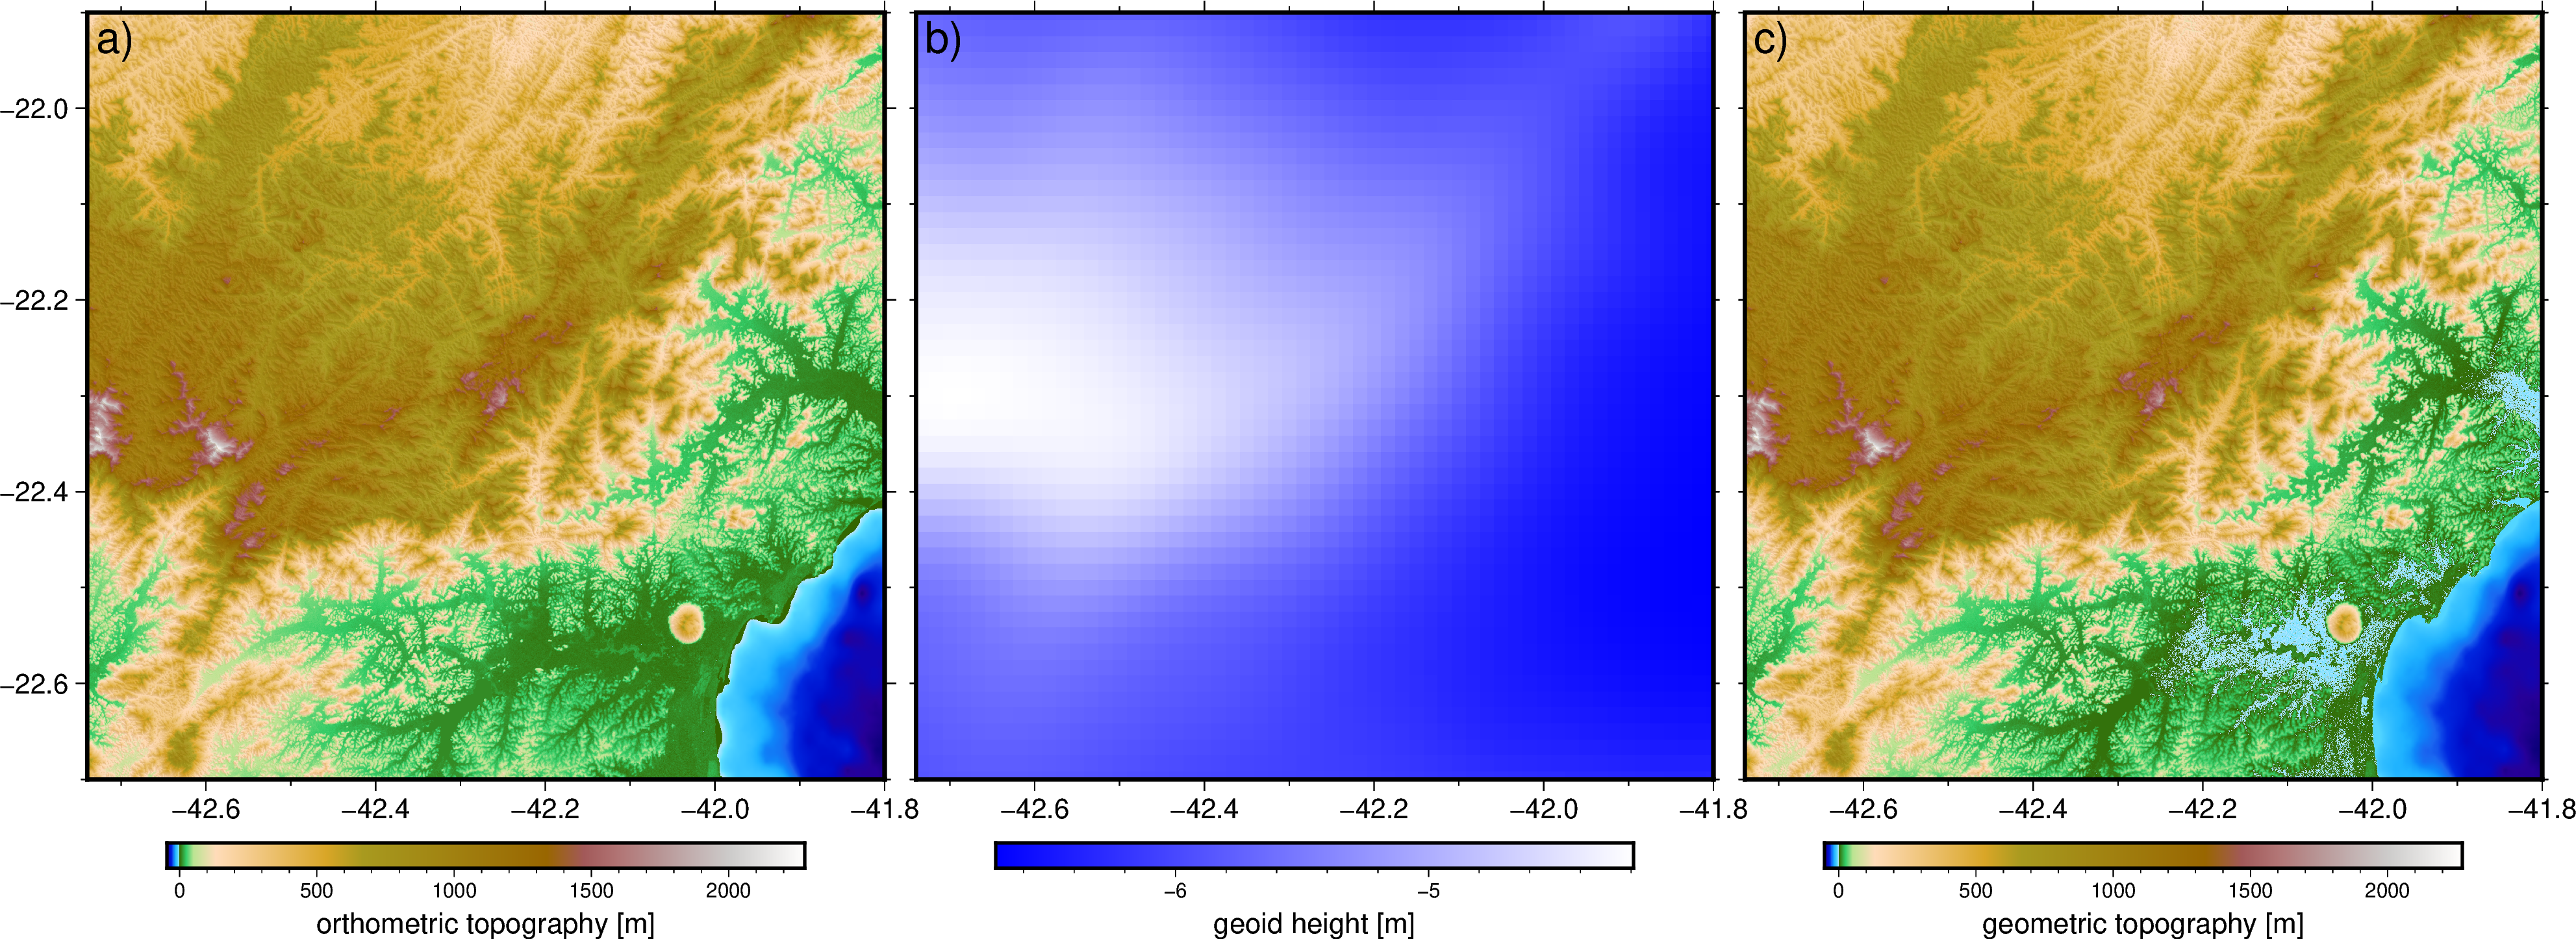

In [12]:
fig = pygmt.Figure()
with fig.subplot(
    nrows=1, ncols=3, figsize=("32c", "10c"), autolabel=True, margins="-0.05c"
):
    with fig.set_panel(panel=0):
        fig.grdimage(
            topography,
            projection="X",
            cmap="etopo1",
            frame=["WSne", "xaf", "yaf"],
            shading="+a45+nt0.15",
        )
        fig.colorbar(frame="af+lorthometric topography [m]")
    with fig.set_panel(panel=1):
        fig.grdimage(geoid, projection="X", cmap="polar+h", frame=["WSne", "xaf", "f"])
        fig.colorbar(frame="af+lgeoid height [m]")
    with fig.set_panel(panel=2):
        fig.grdimage(
            topography_geometric,
            projection="X",
            cmap="etopo1",
            frame=["WSne", "xaf", "f"],
            shading="+a45+nt0.15",
        )
        fig.colorbar(frame="af+lgeometric topography [m]")
fig.show(width=1000)

Finally, we can interpolate the geometric heights of topography on the observation points and add the altitude to obtain the geometric flight heights.

In [13]:
table = vd.grid_to_table(topography_geometric)
kn = vd.KNeighbors().fit((table.longitude, table.latitude), table.z)
data = data.assign(
    geometric_height_m=data.altitude_m + kn.predict((data.longitude, data.latitude))
)
data.head()

longitude   latitude  total_field_anomaly_nT  altitude_m  line_number  \
0 -42.640141 -22.290868                  -16.56      151.49         2800   
1 -42.640126 -22.291738                  -43.47      162.46         2800   
2 -42.640111 -22.292608                  -65.38      170.69         2800   
3 -42.640095 -22.293493                  -74.29      173.43         2800   
4 -42.640080 -22.294363                  -67.20      170.08         2800   

      easting_m    northing_m  geometric_height_m  
0 -4.393933e+06 -2.342247e+06         1409.274167  
1 -4.393932e+06 -2.342343e+06         1444.244000  
2 -4.393930e+06 -2.342440e+06         1418.474000  
3 -4.393929e+06 -2.342538e+06         1368.214000  
4 -4.393927e+06 -2.342634e+06         1362.864000

## Calculate derivatives

We'll calculate the data derivatives in 3 dimensions using equivalent sources. This way, we can use a finite-difference approximation to get the derivatives on the observation points, without the needed for gridding. This will help us preserve the data wavelengths and avoid smoothing effects on the derivatives.

In [14]:
%%time
eqs = hm.EquivalentSourcesGB(
    damping=1e1,
    depth=1000,
    block_size=100,
    random_state=42,
)
coordinates = (data.easting_m, data.northing_m, data.geometric_height_m)
eqs.fit(coordinates, data.total_field_anomaly_nT)

CPU times: user 5min 31s, sys: 32.9 s, total: 6min 4s
Wall time: 37.6 s


EquivalentSourcesGB(block_size=100, damping=10.0, depth=1000, random_state=42)

Now use data predictions at shifted coordinates to get a finite-difference approximation of the derivatives.

In [15]:
delta = 1
data["deriv_up"] = (
    eqs.predict((data.easting_m, data.northing_m, data.geometric_height_m + delta / 2))
    - eqs.predict(
        (data.easting_m, data.northing_m, data.geometric_height_m - delta / 2)
    )
) / delta
data["deriv_east"] = (
    eqs.predict((data.easting_m + delta / 2, data.northing_m, data.geometric_height_m))
    - eqs.predict(
        (data.easting_m - delta / 2, data.northing_m, data.geometric_height_m)
    )
) / delta
data["deriv_north"] = (
    eqs.predict((data.easting_m, data.northing_m + delta / 2, data.geometric_height_m))
    - eqs.predict(
        (data.easting_m, data.northing_m - delta / 2, data.geometric_height_m)
    )
) / delta

## Plot the data and derivatives

Make a quick plot for inspection only.

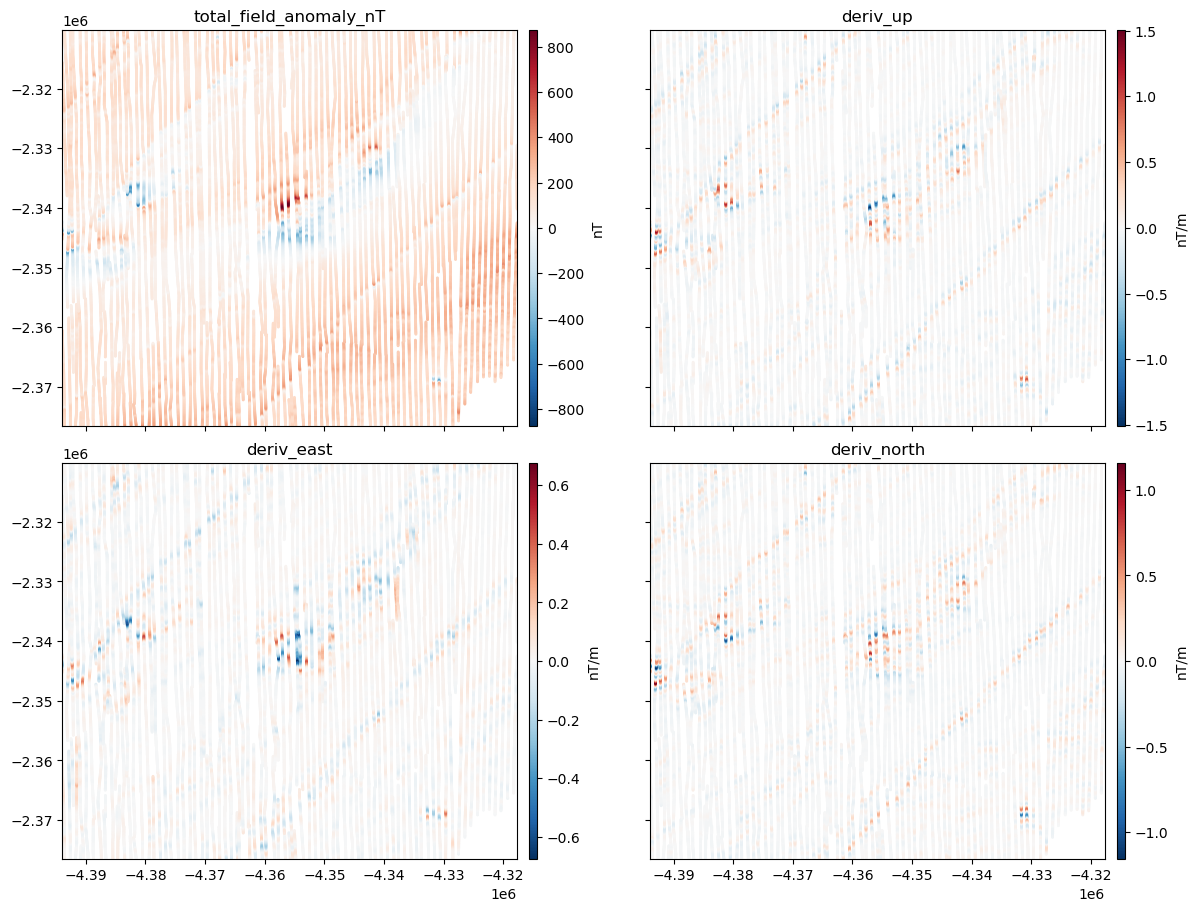

In [16]:
fig, axes = plt.subplots(
    2, 2, figsize=(12, 9), sharex=True, sharey=True, layout="constrained"
)
for ax in axes.ravel():
    ax.set_aspect("equal")
    ax.set_xlim(data.easting_m.min(), data.easting_m.max())
    ax.set_ylim(data.northing_m.min(), data.northing_m.max())

variables = [
    "total_field_anomaly_nT",
    "deriv_up",
    "deriv_east",
    "deriv_north",
]
units = ["nT", "nT/m", "nT/m", "nT/m"]
for ax, var, unit in zip(axes.ravel(), variables, units):
    scale = vd.maxabs(data[var])
    ax.set_title(var)
    tmp = ax.scatter(
        data.easting_m,
        data.northing_m,
        s=1,
        c=data[var],
        vmin=-scale,
        vmax=scale,
        cmap="RdBu_r",
    )
    fig.colorbar(tmp, ax=ax, label=unit, aspect=50, pad=0.01, orientation="vertical")
plt.show()

## Export calculations to files for later loading

Save the magnetic data to a CSV file and topography grid in geometric heights to netCDF.

In [17]:
data.to_csv(processed_dir / "rio-de-janeiro-magnetic.csv", index=False)
topography_geometric.to_netcdf(
    processed_dir / "rio-de-janeiro-topography.nc",
    format="NETCDF4",
    encoding={
        "z": {
            "zlib": True,
            "dtype": "int16",
        },
    },
)

## Export a LaTeX file with information for the manuscript

Save things we want to include on the paper so that they can be referenced instead of copied.

In [18]:
output = rf"""
\newcommand{{\RioNData}}{{\num{{{data.shape[0]}}}}}
\newcommand{{\RioDerivSpacing}}{{\qty{{{delta}}}{{\m}}}}
\newcommand{{\RioEQSDepth}}{{\qty{{{eqs.depth}}}{{\m}}}}
\newcommand{{\RioEQSDamping}}{{\num{{{eqs.damping:.0f}}}}}
\newcommand{{\RioEQSBlock}}{{\qty{{{eqs.block_size}}}{{\m}}}}
\newcommand{{\RioEQSWindow}}{{\qty{{{eqs.window_size_:.0f}}}{{\m}}}}
""".strip()
path = pathlib.Path("..") / "paper" / "variables" / "real-data-preparation.tex"
path.write_text(output)
print(output)

\newcommand{\RioNData}{\num{50882}}
\newcommand{\RioDerivSpacing}{\qty{1}{\m}}
\newcommand{\RioEQSDepth}{\qty{1000}{\m}}
\newcommand{\RioEQSDamping}{\num{10}}
\newcommand{\RioEQSBlock}{\qty{100}{\m}}
\newcommand{\RioEQSWindow}{\qty{22313}{\m}}
